


James Bay Coordinates
53°30′N 80°30′W



In [1]:

# Data related libraries
import numpy as np
import netCDF4 as nc
import glob
import os

# Plotting related libraries
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()                
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Machine specific libraries
from sys import platform



In [2]:
#Setting up machine specific path

if platform == "linux" or platform == "linux2":
    # linux
    
    # setup paths
    mask_path = '/mnt/storage0/jmarson/ANALYSES/MASKS/'
    data_path = '/mnt/storage0/jmarson/NEMO/ANHA4/ANHA4-EPM111-S/'
    
elif platform == "darwin":
    # OS X

    # setup paths
    data_path = '/Users/jeenriquez/Documents/CEOS/Test_Data/'
    mask_path = '/Users/jeenriquez/Documents/CEOS/Test_Data/'
        
# Get complete file list from path
file_list = os.listdir(data_path)




# File selection given platform and other parameters
if platform == "linux" or platform == "linux2":
    
    #selecting list of files given params
    file_list = sorted([ f for f in file_list if 'y'+year in f and 'grid'+grid in f])

    #Set data list params
    year= '1958'
    grid = 'T'
    month_list = ['04','05','06','07','08','09','10','11','12']

    new_file_list =[]
    
    for month in month_list:
        file_name_stump = 'y{}m{}'.format(year,month)
        file_month_name = [ f for f in file_list if file_name_stump in f ][0]
        new_file_list.append(file_month_name)
    
    file_list = new_file_list
    
elif platform == "darwin":

    #Set data list params
    year= '1998'
    grid = 'T'
    
    # Selecting list of files given params
    file_list = sorted([ f for f in file_list if 'y'+year in f and 'grid'+grid in f])


# Adding full path to filenames
file_list = [data_path+filename for filename in file_list]



In [3]:
# Setting up model parameters based on Hudson Bay and James Bay locations. 
            
Hudson_bay = False           # Boolean if using Hudson Bay vs James Bay locations.
depth = 0                    # z axis location from 50 unit "depth" 

if Hudson_bay: 
    x_range = (330,500)      # x axis range related to Longitude range for Hudson Bay
    y_range = (20,120)       # y axis range related to Latitude range for Hudson Bay
    
    proj_size = 2
    region = 'HudsonBay'
    
else:
    x_range = (335,390)      # x axis range related to Longitude range for James Bay 
    y_range = (55,105)       # y axis range related to Latitude range for James Bay
    
    proj_size = 4
    region = 'JamesBay'
    

In [4]:
# Reading ANHA4 mask data
mask = nc.Dataset(mask_path+"ANHA4_mask.nc")

# Extracting mask data for given depth
tmask = mask['tmask'][0][depth]

# Creating mask frame to use in given location. 
surf_mask = np.zeros(np.shape(tmask))

# Populating mask array with nan values where there is ocean model data, to effectively mask the surface.
for i in range(x_range[0], x_range[1]):
    for j in range(y_range[0], y_range[1]):
        if tmask[i][j] == 1.:
            surf_mask[i][j] = np.nan

# Extract selected region.            
surf_mask = surf_mask[x_range[0]:x_range[1],y_range[0]:y_range[1]]


In [5]:
# Reading lat and long


def get_lat_lon(data,xrange,yrange):
    """  Getting Latitude and Longitude """
    
    lat = data['nav_lat_grid_T'][x_range[0]:x_range[1],y_range[0]:y_range[1]]
    lon = data['nav_lon_grid_T'][x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    return lat,lon


In [6]:

def get_lat_lon_ticks(lat,lon):
    """Setting up lat long tick marks"""

    # Find indices with no zeros 
    lat_valid_index = lat[:,0].nonzero()[0]
    lon_valid_index = lon[0,:].nonzero()[0]

    # Calculate the tick values 
    numer_of_ticks = 5
    lat_tick_indices = np.arange(lat_valid_index[0],lat_valid_index[-1],lat_valid_index[-1]//(numer_of_ticks-1))
    lon_tick_indices = np.arange(lon_valid_index[0],lon_valid_index[-1],lon_valid_index[-1]//(numer_of_ticks-2))

    # Degree symbol
    deg = u'\xb0'

    # Simple way to get cardinal locations, assuming all values are in the same cartesian quadrant. 
    if min_lat > 0:
        card_ns = 'N'
    else:
        card_ns = 'S'

    if min_lon > 0:
        card_ew = 'E'
    else:
        card_ew = 'W'

    # Find lat and long values for ticks
    lat_tick_values = [ '%.1f%s%s'%(i,deg,card_ns) for i in list(lat[lat_tick_indices,0].data)]
    lon_tick_values = [ '%.1f%s%s'%(i,deg,card_ew) for i in list(lon[0,lon_tick_indices].data)]

    return lat_tick_indices,lon_tick_indices,lat_tick_values,lon_tick_values
    


#### plotting multiple dates

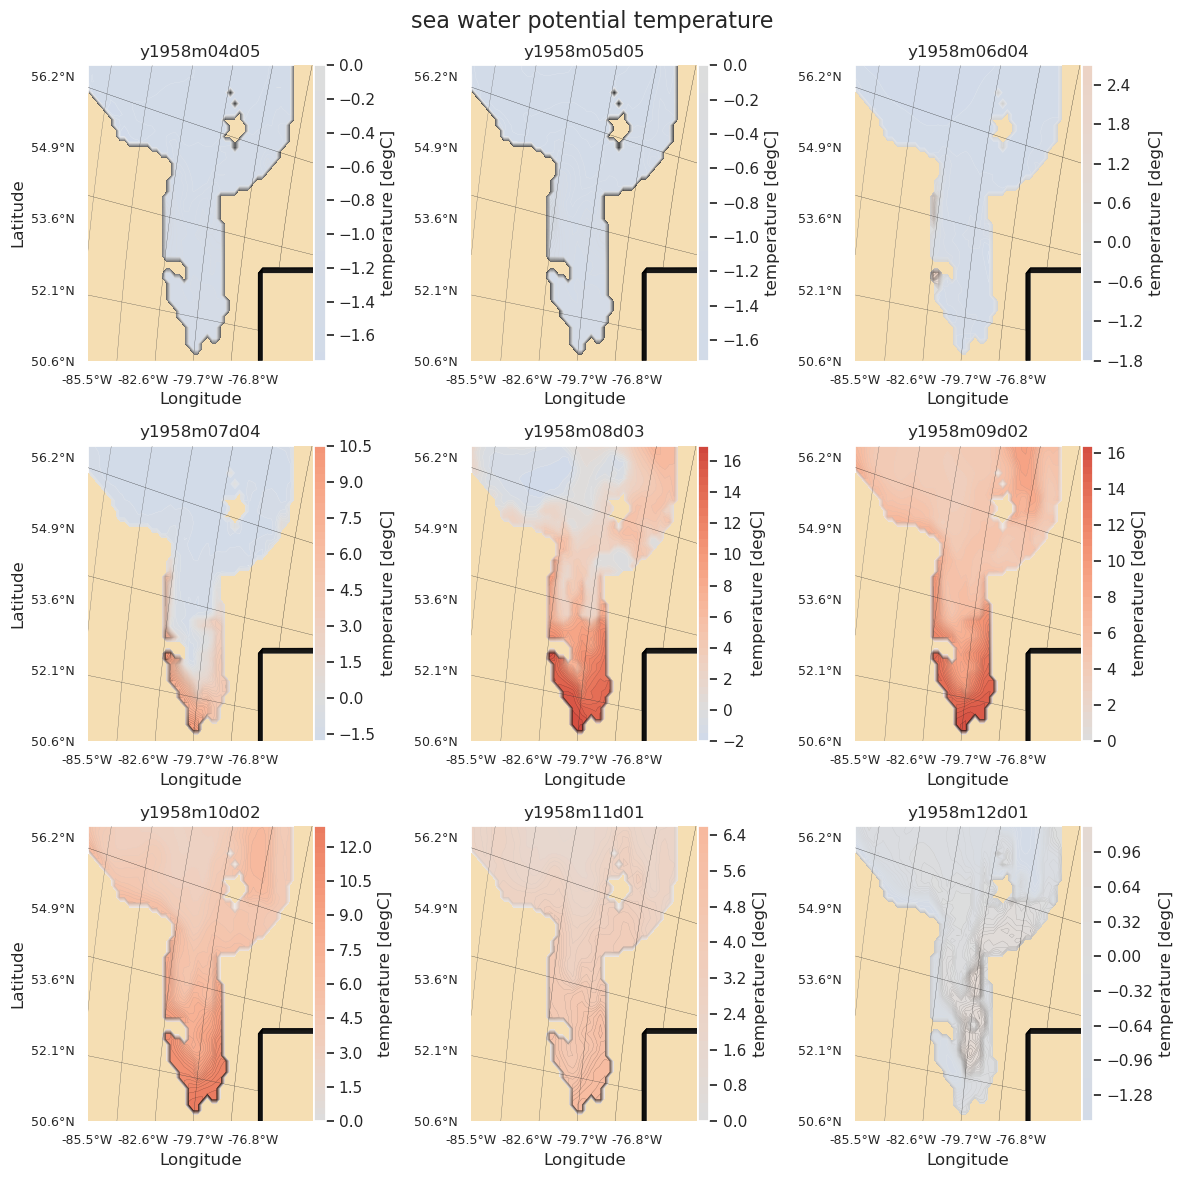

In [7]:


# Setting ploting vars.
levels = 42

vmax=20.
vmin=-20.

# Choosing variable to plot 
var =  'votemper'

# Setting up figure
ncols = 3
nrows = len(file_list)//ncols
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=[ncols*4,nrows*4])

for i, xx in enumerate(fig.axes):
            
    # Get data
    data = nc.Dataset(file_list[i])
    temp = data[var][:]

    # Cut data
    temp = temp[0,depth,x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    #getting lat and lon 
    if i == 0:
        lat, lon = get_lat_lon(data,x_range,y_range)
        max_lat = lat.data[lat.data!=0].max()
        min_lat = lat.data[lat.data!=0].min()
        max_lon = lon.data[lon.data!=0].max()
        min_lon = lon.data[lon.data!=0].min()
        
        lon_levels = int(abs( max_lon - min_lon ))
        lat_levels = int(abs( max_lat - min_lat ))       
    
        lat_tick_indices,lon_tick_indices,lat_tick_values,lon_tick_values = get_lat_lon_ticks(lat,lon)
    
    
    # Plotting data
    #plotting filled countour regions 
    im = xx.contourf(temp,levels=levels,cmap='coolwarm',vmin=vmin,vmax=vmax)

    # Plotting data countor lines
    xx.contour(temp,levels=levels,cmap='Greys',linewidths=.1)
    #plt.contour(test_var[0,depth,x_range,20:120],levels=levels,cmap='Greys',linewidths=.2,vmin=vmin,vmax=vmax)
    #plt.colorbar()

    # Surface mask.
    xx.contourf(surf_mask, colors= 'wheat', zorder = 3)

    # Plotting lat lon contour lines
    xx.contour(lat,levels=lat_levels*proj_size,cmap='binary',vmin=min_lat-20,vmax=max_lat,linewidths=.2, zorder = 3)
    xx.contour(lon,levels=lon_levels*proj_size,cmap='binary',vmin=min_lon-20,vmax=max_lon,linewidths=.2, zorder = 3)
    
    
    # Set axis labels
    xx.set_xlabel('Longitude')
    if i % ncols == 0:
        xx.set_ylabel('Latitude')

    # Set title
    #plt.title(data.variables['votemper'].standard_name)
    xx.set_title(file_list[i].split('/')[-1].split('_')[1])
    
    # Set tick marks
    xx.set_yticks(ticks = lat_tick_indices , labels= lat_tick_values, fontsize = 9)    
    xx.set_xticks(ticks = lon_tick_indices , labels= lon_tick_values, fontsize = 9)
    
    # Set Colorbar
    divider = make_axes_locatable(xx)
    cax = divider.append_axes('right', size='5%', pad=0.01)
    label = data.variables[var].long_name+' ['+data.variables[var].units+']'
    fig.colorbar(im, cax=cax, orientation='vertical',label=label)

fig.suptitle(data.variables[var].standard_name.replace('_',' '), fontsize=16)
fig.tight_layout()



#Save figure to file.
plt.savefig('../figs/%s_%s_y%s_m%s-%s.png'%(region,data.variables[var].long_name,year,month_list[0],month_list[-1]))
